# Predcition of Hospital Admission Related to Upper Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to ipper respiratory tract infection (URTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [68]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [69]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [70]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [71]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_date_'+str(i), 'urti_ab_date_'+str(i), 'urti_ab_type_'+str(i),
                   'incdt_urti_date_'+str(i), 'admitted_urti_date_'+str(i), 'sgss_gp_cov_urti_date_'+str(i)]]
    
    #drop rows with no urti reord
    datum = datum[datum['urti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_i
    datum = datum[datum['sgss_gp_cov_urti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_date_'+str(i): 'urti_date', 'urti_ab_date_'+str(i): 'urti_ab_date', 
                           'urti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_date_'+str(i): 'incdt_urti_date', 'incdt_urti_type_'+str(i): 'incdt_urti_type',
                           'admitted_urti_date_'+str(i): 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_'+str(i): 'sgss_gp_cov_urti_date'},
                inplace=True)
    
    return datum

In [72]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [73]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_urti_admitted',
            event_col='event_urti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_urti_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [112]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    print(lr.summary())

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #save and print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [75]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   #'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_status_smoker', 'smoking_status_never_smoked', 'smoking_status_unknown', #'smoking_status_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [76]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [77]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')

In [78]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [79]:
#process 20 urtis and concatenate them 
data_urti_1 = proc_infec_data(data,1)
data_urti_2 = proc_infec_data(data,2)
data_urti_3 = proc_infec_data(data,3)
data_urti_4 = proc_infec_data(data,4)
data_urti_5 = proc_infec_data(data,5)
data_urti_6 = proc_infec_data(data,6)
data_urti_7 = proc_infec_data(data,7)
data_urti_8 = proc_infec_data(data,8)
data_urti_9 = proc_infec_data(data,9)
data_urti_10 = proc_infec_data(data,10)
data_urti_11 = proc_infec_data(data,11)
data_urti_12 = proc_infec_data(data,12)
data_urti_13 = proc_infec_data(data,13)
data_urti_14 = proc_infec_data(data,14)
data_urti_15 = proc_infec_data(data,15)
data_urti_16 = proc_infec_data(data,16)
data_urti_17 = proc_infec_data(data,17)
data_urti_18 = proc_infec_data(data,18)
data_urti_19 = proc_infec_data(data,19)
data_urti_20 = proc_infec_data(data,20)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4, data_urti_5, data_urti_6, data_urti_7, data_urti_8, data_urti_9, data_urti_10, data_urti_11, data_urti_12, data_urti_13, data_urti_14, data_urti_15, data_urti_16, data_urti_17, data_urti_18, data_urti_19, data_urti_20])
data_urti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [80]:
##add variable season
#convert data types
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['urti_date'] 
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti = data_urti[data_urti['date'] != last_1_month_date_y_m]
data_urti = data_urti[data_urti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti['season'] = np.select(conditions, choices, default='winter')

In [81]:
#add variable time period
data_urti.loc[(data_urti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti.loc[((data_urti['date'] >= '2020-05') & (data_urti['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_urti.loc[(data_urti['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

In [82]:
data_urti['date'].max()

'2023-04'

#### event and duration

In [83]:
#scenario 1
#not hosped (nothing happened)
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0

In [84]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]

In [85]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0

#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [86]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30

#give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [87]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [88]:
#drop anybody with age less than 18 or 0!
data_urti = data_urti[~(data_urti['age'] < 18)] 
data_urti['age'][data_urti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti = data_urti[data_urti['age_cat'] != '0-4']
data_urti = data_urti[data_urti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

In [89]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking_status = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking_status": dict_smoking_status})

In [90]:
#drop rows with missing region
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
   data_urti = data_urti[data_urti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

#replace rows with missing smoking_status with 0
if ('smoking_status' in data_urti.columns) and (data_urti['smoking_status'].isnull().sum() > 0):
    data_urti['smoking_status'] = data_urti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    data_urti['imd'] = data_urti['imd'].fillna(0)

In [91]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti['bmi_cat'] = 5

for idx, x in enumerate(data_urti['bmi_cat']):
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 30:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 25) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 30):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 18.5) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 25):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 18.5:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

In [92]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti['ab_type_cat'] = np.where(data_urti['ab_type'].isin(ab_series[mask].index),'other',data_urti['ab_type'])
#assign no to non ab users
data_urti.loc[data_urti['urti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti['ab_type_cat'] = data_urti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [93]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking_status = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking_status": dict_smoking_status})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
data_urti = data_urti.replace({"ab_type_cat": dict_ab_type})

In [94]:
data_urti.ethnicity.value_counts('NA')

white      0.600261
unknown    0.248757
other      0.076141
asian      0.074841
Name: ethnicity, dtype: float64

In [95]:
data_urti.smoking_status.value_counts('NA')

unknown         0.416160
smoker          0.388983
never_smoked    0.129145
ex_smoker       0.065712
Name: smoking_status, dtype: float64

In [96]:
data_urti.bmi_cat.value_counts('NA')

obese             0.520452
unknown           0.254621
overweight        0.112336
healthy_weight    0.080955
underweight       0.031636
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [97]:
#categorise CCI
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti['antibacterial_brit'].clip(0, data_urti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

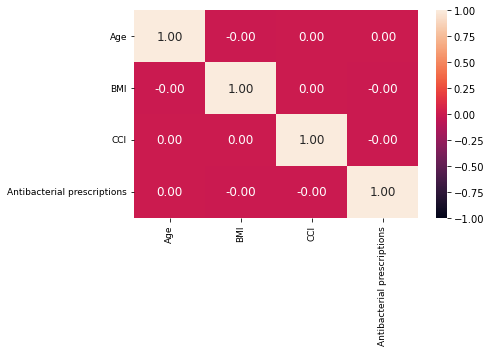

In [98]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [99]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'urti_ab_date', 'ab_type_cat', 'incdt_urti_date', 'date', 'period',
                                   'event_urti_admitted', 'duration_urti_admitted'
                                    ]]

In [100]:
#switch variable urti_ab_date into a binary variable
data_urti[['ab_binary']] = data_urti[['urti_ab_date']].where(data_urti[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_urti_incdt = data_urti[data_urti['incdt_urti_date'] == 0]
data_urti_prevl = data_urti[data_urti['incdt_urti_date'] == 1]

#no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti_incdt[data_urti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti_incdt[data_urti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti_prevl[data_urti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti_prevl[data_urti_prevl['ab_binary'] == 1]

In [101]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_urti_incdt_prepandemic = data_urti_incdt[data_urti_incdt['period'] == 'prepandemic']
data_urti_incdt_during_pandemic = data_urti_incdt[(data_urti_incdt['period'] == 'during_pandemic')]
data_urti_incdt_post_2nd_lockdown = data_urti_incdt[data_urti_incdt['period'] == 'post_2nd_lockdown']
data_urti_prevl_prepandemic = data_urti_prevl[data_urti_prevl['period'] == 'prepandemic']
data_urti_prevl_during_pandemic = data_urti_prevl[(data_urti_prevl['period'] == 'during_pandemic')]
data_urti_prevl_post_2nd_lockdown = data_urti_prevl[data_urti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_urti_no_abs_incdt_prepandemic = data_urti_incdt_prepandemic[data_urti_incdt_prepandemic['ab_binary'] == 0]
data_urti_no_abs_incdt_during_pandemic = data_urti_incdt_during_pandemic[data_urti_incdt_during_pandemic['ab_binary'] == 0]
data_urti_no_abs_incdt_post_2nd_lockdown = data_urti_incdt_post_2nd_lockdown[data_urti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_urti_no_abs_prevl_prepandemic = data_urti_prevl_prepandemic[data_urti_prevl_prepandemic['ab_binary'] == 0]
data_urti_no_abs_prevl_during_pandemic = data_urti_prevl_during_pandemic[data_urti_prevl_during_pandemic['ab_binary'] == 0]
data_urti_no_abs_prevl_post_2nd_lockdown = data_urti_prevl_post_2nd_lockdown[data_urti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [102]:
#store data for plotting hosp admission counts and percentages
%store data_urti
# save data
data_urti.to_csv('../output/hospitalisation_prediction_urti/data_urti.csv')

Stored 'data_urti' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [103]:
#make summary tables
make_summary_table('urti', 'no_abs_incdt', data_urti_no_abs_incdt)
make_summary_table('urti', 'abs_incdt', data_urti_abs_incdt)
make_summary_table('urti', 'no_abs_prevl', data_urti_no_abs_prevl)
make_summary_table('urti', 'abs_prevl', data_urti_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 109983 total observations, 109265 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 109983
number of events observed = 718
   partial log-likelihood = -8316.97
         time fit was run = 2023-07-15 12:50:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.11            -0.27             0.16                 0.76                 1.17
CCI_cat[T.medium]                0.06       1.07       0.12            -0.17             0.30                 0.84                 1.35
CCI_cat[T.high]                 -0.07       0.93       0.15            -0.36             0.22                 0.70                 1.24
CCI_cat[T.very_high]            -0.17       0.84       0.13            -0.43             0.09                 0.65                 1.09
age_cat[T.25_34]                -0.07       0.93       0.14            -0.35             0.20                 0.71                 1.22
age_cat[T.35_44]                -0.10       0.90       0.14            -0.38             0.17                 0.68                 1.19
age_cat[T.45_54]                -0.20       0.82       0.14            -0.48             0.08                 0.62                 1.09
age_cat[T.55_64]                 0.14       1.16       0.13            -0.12             0.41                 0.89                 1.50
age_cat[T.65_74]                 0.06       1.06       0.14            -0.21             0.32                 0.81                 1.38
age_cat[T.75_more]              -0.08       0.92       0.14            -0.35             0.20                 0.70                 1.22
antibacterial_brit               0.01       1.01       0.03            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                 0.02       1.02       0.14            -0.25             0.29                 0.78                 1.34
bmi_cat[T.overweight]           -0.09       0.92       0.17            -0.43             0.26                 0.65                 1.29
bmi_cat[T.underweight]           0.13       1.14       0.24            -0.33             0.60                 0.72                 1.82
bmi_cat[T.unknown]              -0.05       0.95       0.15            -0.35             0.25                 0.71                 1.28
ethnicity[T.other]               0.14       1.15       0.19            -0.25             0.52                 0.78                 1.68
ethnicity[T.unknown]            -0.06       0.94       0.16            -0.38             0.26                 0.68                 1.30
ethnicity[T.white]               0.16       1.17       0.15            -0.14             0.45                 0.87                 1.57
flu_vaccine[T.yes]               0.03       1.03       0.12            -0.21             0.27                 0.81                 1.31
imd[T.medium]                    0.05       1.05       0.12            -0.18             0.29                 0.83                 1.33
imd[T.unaffluent]                0.05       1.06       0.12            -0.18             0.29                 0.84                 1.33
imd[T.unknown]                   0.09       1.09       0.18            -0.27             0.45                 0.77                 1.56
imd[T.very_affluent]             0.00       1.00       0.12            -0.24             0.24                 0.79                 1.27
imd[T.very_unaffluent]          -0.13       0.88       0.13            -0.38             0.11                 0.69                 1.12
region[T.east_midlands]         -0.10       0.91       0.18      

13042


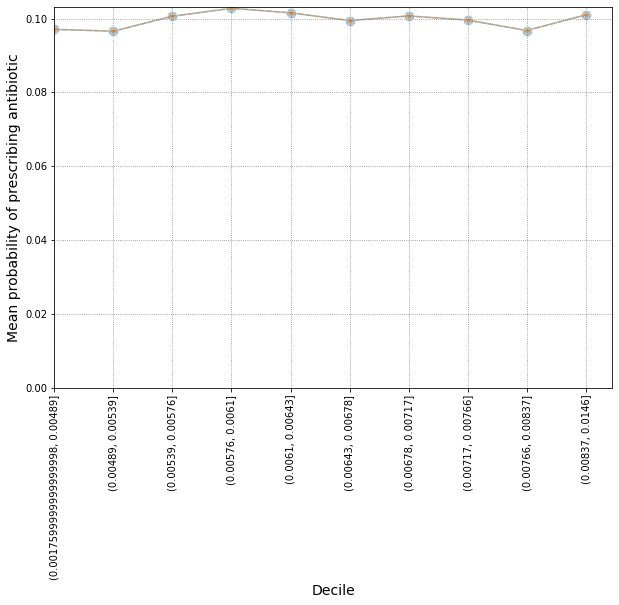

                           Logit Regression Results                           
Dep. Variable:              ab_binary   No. Observations:               122151
Model:                          Logit   Df Residuals:                   122142
Method:                           MLE   Df Model:                            8
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                 -0.1133
Time:                        13:50:35   Log-Likelihood:                -44071.
converged:                       True   LL-Null:                       -39588.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
bins_(0.00489, 0.00539]    -2.2397      0.031    -73.204      0.000      -2.300      -2.180
bins_(0.00539, 0.00576]    -2.1980      0.030    -72.625      0.000      -2.257      -2.139


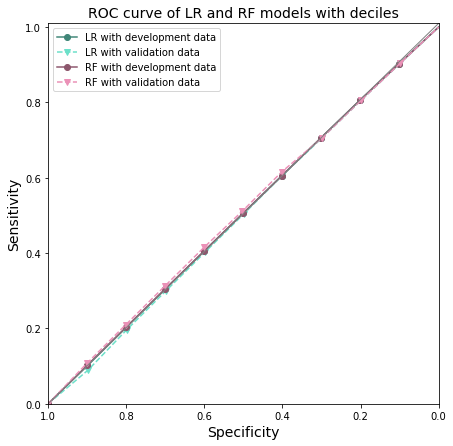

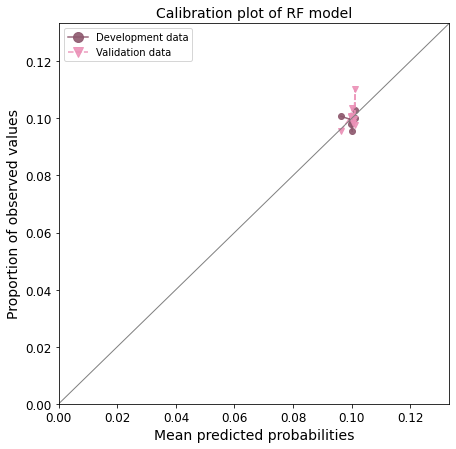

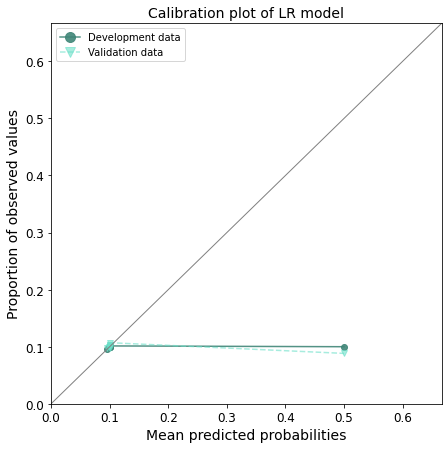


AUROC of LR for risk factors with development and validation data: 0.50077 and 0.50070
AUROC of RF for risk factors with development and validation data: 0.59698 and 0.50254
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_25_34                0.729312  0.683722  0.777942
age_cat_35_44                0.778688  0.730677  0.829854
age_cat_45_54                0.694281  0.650462  0.741051
age_cat_55_64                0.732628  0.686373  0.781999
age_cat_65_74                0.741509  0.695308  0.790781
age_cat_75_more              0.731952  0.686147  0.780815
sex_male                     0.911992  0.879204  0.946002
CCI_cat_high                 0.775378  0.723345  0.831154
CCI_cat_low                  0.766171  0.728555  0.805728
CCI_cat_medium               0.767616  0.725017  0.812717
CCI_cat_very_high            0.752996  0.708870  0.799870
flu_vaccine_yes              0.963671  0.905326  1.025777
bmi_cat_obese                0.630099  0.595916  0.66

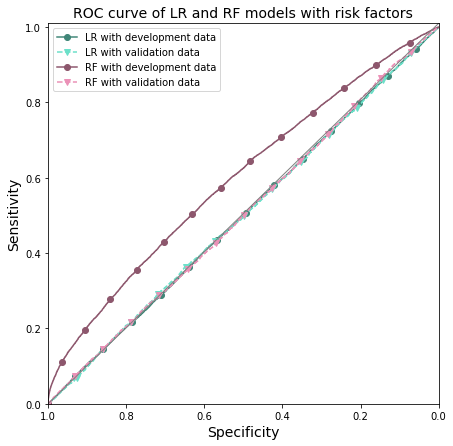

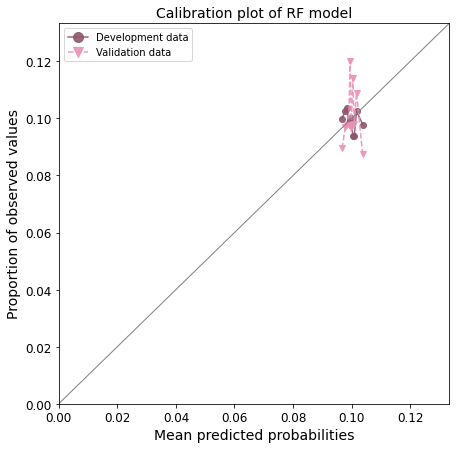

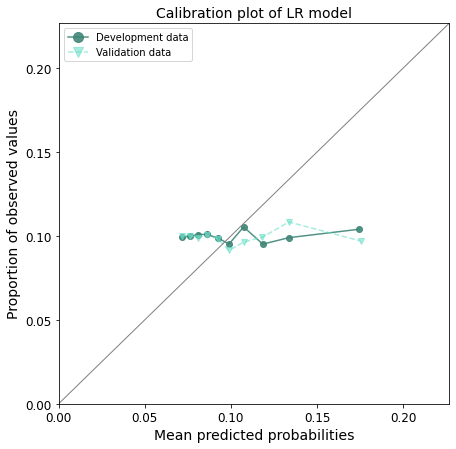

In [113]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt, prob_pred_urti_no_abs_incdt_bin = cox_build('urti', 'incdt', data_urti_incdt, data_urti_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models with deciles as predictors
    prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('urti', 'incdt_deciles', prob_pred_urti_no_abs_incdt)
    #calibration plots of rf and lr with deciles
    calibration_rf_lr('urti', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

try:
    #build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('urti', 'incdt_riskfactors', prob_pred_urti_no_abs_incdt)
    #calibration plots of rf and lr with risk factors
    calibration_rf_lr('urti', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)
except:
    print("error_4: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12032 total observations, 11961 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 12032
number of events observed = 71
   partial log-likelihood = -649.14
         time fit was run = 2023-07-15 12:38:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.07       0.36            -0.64             0.78                 0.53                 2.18
CCI_cat[T.medium]               -0.35       0.70       0.44            -1.21             0.51                 0.30                 1.66
CCI_cat[T.high]                  0.22       1.24       0.45            -0.66             1.10                 0.51                 3.01
CCI_cat[T.very_high]             0.38       1.47       0.39            -0.39             1.15                 0.68                 3.17
age_cat[T.25_34]                -0.12       0.88       0.42            -0.94             0.70                 0.39                 2.00
age_cat[T.35_44]                -0.13       0.88       0.42            -0.95             0.69                 0.39                 1.99
age_cat[T.45_54]                -0.25       0.78       0.43            -1.09             0.59                 0.34                 1.81
age_cat[T.55_64]                -0.13       0.88       0.41            -0.93             0.68                 0.39                 1.96
age_cat[T.65_74]                -0.64       0.53       0.48            -1.57             0.29                 0.21                 1.34
age_cat[T.75_more]              -0.48       0.62       0.46            -1.38             0.41                 0.25                 1.51
antibacterial_brit               0.13       1.13       0.08            -0.03             0.28                 0.97                 1.33
bmi_cat[T.obese]                 1.04       2.83       0.73            -0.38             2.47                 0.68                11.77
bmi_cat[T.overweight]            1.30       3.66       0.78            -0.22             2.82                 0.80                16.71
bmi_cat[T.underweight]           1.36       3.90       0.91            -0.43             3.15                 0.65                23.39
bmi_cat[T.unknown]               1.18       3.24       0.74            -0.28             2.63                 0.76                13.88
ethnicity[T.other]               0.75       2.12       0.55            -0.33             1.83                 0.72                 6.21
ethnicity[T.unknown]             0.02       1.02       0.51            -0.98             1.02                 0.37                 2.76
ethnicity[T.white]              -0.01       0.99       0.48            -0.94             0.92                 0.39                 2.52
flu_vaccine[T.yes]              -0.43       0.65       0.46            -1.34             0.49                 0.26                 1.62
imd[T.medium]                    0.38       1.46       0.43            -0.46             1.22                 0.63                 3.38
imd[T.unaffluent]                0.51       1.66       0.42            -0.32             1.33                 0.73                 3.80
imd[T.unknown]                   0.48       1.61       0.60            -0.70             1.66                 0.50                 5.25
imd[T.very_affluent]             0.40       1.49       0.43            -0.44             1.24                 0.64                 3.44
imd[T.very_unaffluent]           0.44       1.55       0.42            -0.39             1.27                 0.68                 3.56
region[T.east_midlands]          0.51       1.66       0.63           

13036


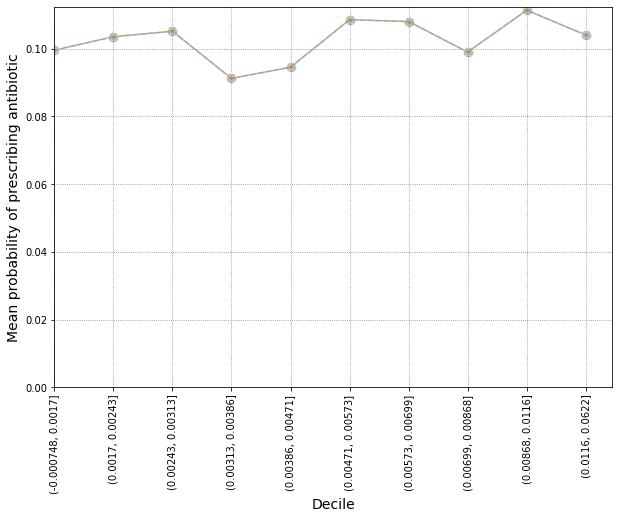

                           Logit Regression Results                           
Dep. Variable:              ab_binary   No. Observations:                13406
Model:                          Logit   Df Residuals:                    13397
Method:                           MLE   Df Model:                            8
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                 -0.1104
Time:                        13:38:58   Log-Likelihood:                -4942.0
converged:                       True   LL-Null:                       -4450.5
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
bins_(0.0017, 0.00243]     -2.1006      0.088    -23.958      0.000      -2.272      -1.929
bins_(0.00243, 0.00313]    -2.1989      0.091    -24.150      0.000      -2.377      -2.020


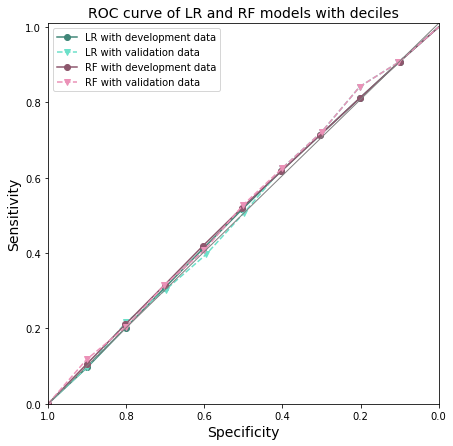

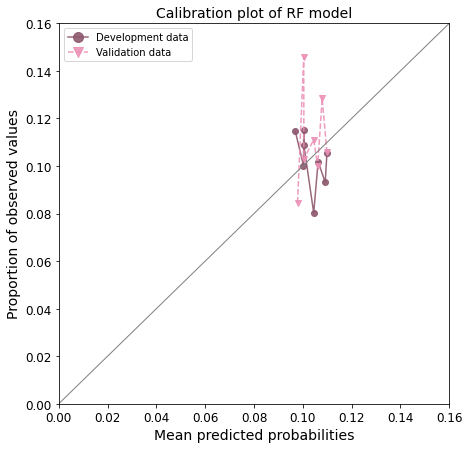

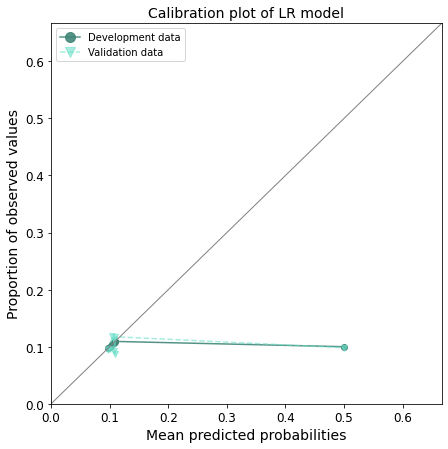


AUROC of LR for risk factors with development and validation data: 0.53836 and 0.48278
AUROC of RF for risk factors with development and validation data: 0.75013 and 0.51520
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_25_34                0.782318  0.643071  0.951717
age_cat_35_44                0.856949  0.706927  1.038809
age_cat_45_54                0.762402  0.626733  0.927439
age_cat_55_64                0.770437  0.634100  0.936087
age_cat_65_74                0.750276  0.616816  0.912612
age_cat_75_more              0.849491  0.701953  1.028040
sex_male                     0.935070  0.838292  1.043020
CCI_cat_high                 0.859269  0.697422  1.058674
CCI_cat_low                  0.789395  0.677487  0.919789
CCI_cat_medium               0.897655  0.758626  1.062163
CCI_cat_very_high            0.830979  0.693503  0.995708
flu_vaccine_yes              0.982844  0.819079  1.179350
bmi_cat_obese                0.577402  0.489730  0.68

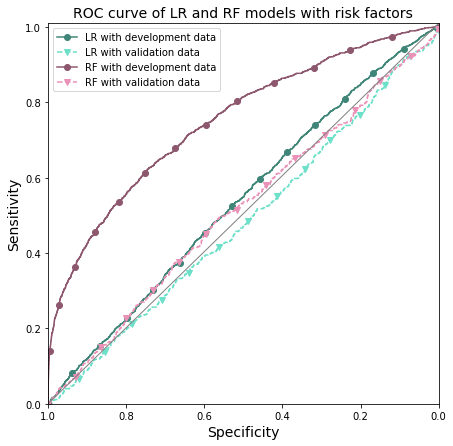

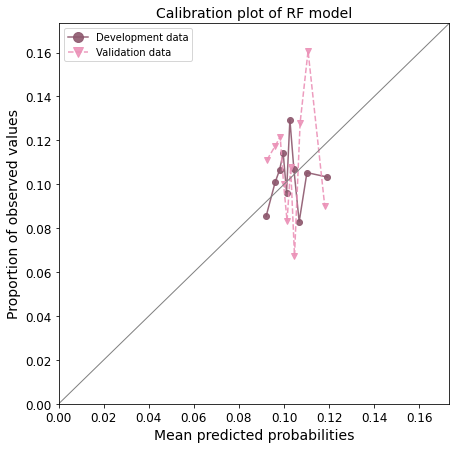

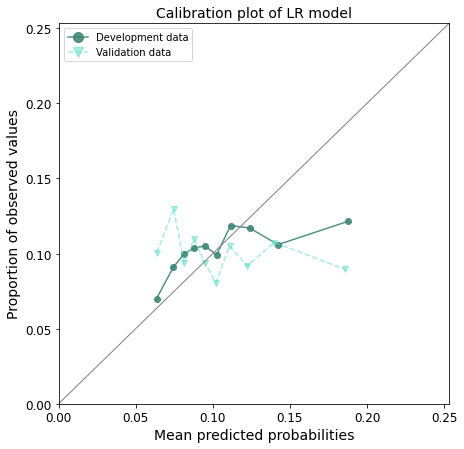

In [105]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl, prob_pred_urti_no_abs_prevl_bin = cox_build('urti', 'prevl', data_urti_prevl, data_urti_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models with deciles as predictors
    prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('urti', 'prevl_deciles', prob_pred_urti_no_abs_prevl)
    #calibration plots of rf and lr with deciles
    calibration_rf_lr('urti', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

try:
    #build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('urti', 'prevl_riskfactors', prob_pred_urti_no_abs_prevl)
    #calibration plots of rf and lr with risk factors
    calibration_rf_lr('urti', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)
except:
    print("error_4: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28511 total observations, 28345 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 28511
number of events observed = 166
   partial log-likelihood = -1681.36
         time fit was run = 2023-07-15 12:39:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.96       0.23            -0.49             0.40                 0.61                 1.50
CCI_cat[T.medium]               -0.09       0.91       0.26            -0.59             0.41                 0.55                 1.50
CCI_cat[T.high]                 -0.31       0.73       0.33            -0.95             0.33                 0.39                 1.39
CCI_cat[T.very_high]            -0.01       0.99       0.26            -0.52             0.51                 0.59                 1.67
age_cat[T.25_34]                -0.02       0.98       0.28            -0.57             0.52                 0.57                 1.68
age_cat[T.35_44]                -0.17       0.85       0.29            -0.73             0.40                 0.48                 1.49
age_cat[T.45_54]                -0.76       0.47       0.34            -1.43            -0.09                 0.24                 0.91
age_cat[T.55_64]                -0.01       0.99       0.28            -0.55             0.54                 0.58                 1.71
age_cat[T.65_74]                -0.16       0.85       0.29            -0.72             0.40                 0.49                 1.49
age_cat[T.75_more]               0.11       1.11       0.27            -0.42             0.64                 0.66                 1.89
antibacterial_brit               0.04       1.04       0.05            -0.07             0.14                 0.94                 1.16
bmi_cat[T.obese]                -0.11       0.90       0.28            -0.66             0.44                 0.52                 1.55
bmi_cat[T.overweight]            0.27       1.31       0.32            -0.36             0.90                 0.70                 2.46
bmi_cat[T.underweight]           0.35       1.42       0.44            -0.51             1.21                 0.60                 3.34
bmi_cat[T.unknown]              -0.43       0.65       0.32            -1.05             0.19                 0.35                 1.20
ethnicity[T.other]               0.72       2.04       0.40            -0.08             1.51                 0.92                 4.52
ethnicity[T.unknown]             0.19       1.20       0.37            -0.54             0.92                 0.58                 2.50
ethnicity[T.white]               0.35       1.42       0.35            -0.33             1.04                 0.72                 2.82
flu_vaccine[T.yes]               0.17       1.19       0.24            -0.31             0.65                 0.74                 1.92
imd[T.medium]                   -0.05       0.96       0.25            -0.54             0.45                 0.58                 1.57
imd[T.unaffluent]                0.23       1.26       0.24            -0.24             0.70                 0.79                 2.01
imd[T.unknown]                   0.32       1.38       0.35            -0.36             1.01                 0.70                 2.74
imd[T.very_affluent]            -0.09       0.91       0.26            -0.60             0.41                 0.55                 1.51
imd[T.very_unaffluent]          -0.27       0.77       0.27            -0.79             0.26                 0.45                 1.29
region[T.east_midlands]         -0.02       0.98       0.34         

13051


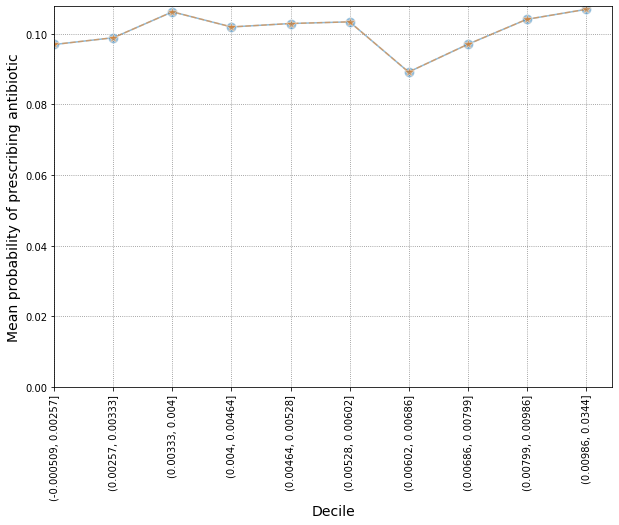

                           Logit Regression Results                           
Dep. Variable:              ab_binary   No. Observations:                31705
Model:                          Logit   Df Residuals:                    31696
Method:                           MLE   Df Model:                            8
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                 -0.1143
Time:                        13:39:08   Log-Likelihood:                -11532.
converged:                       True   LL-Null:                       -10350.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
bins_(0.00257, 0.00333]    -2.1496      0.058    -36.956      0.000      -2.264      -2.036
bins_(0.00333, 0.004]      -2.1075      0.057    -36.855      0.000      -2.220      -1.995


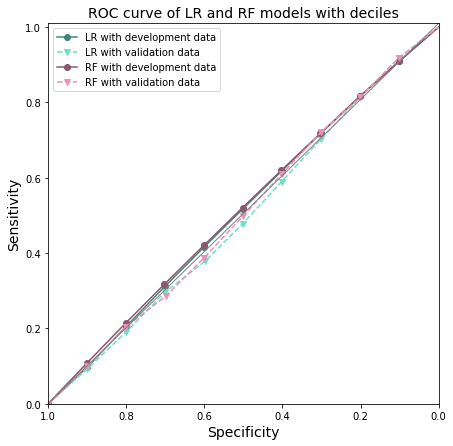

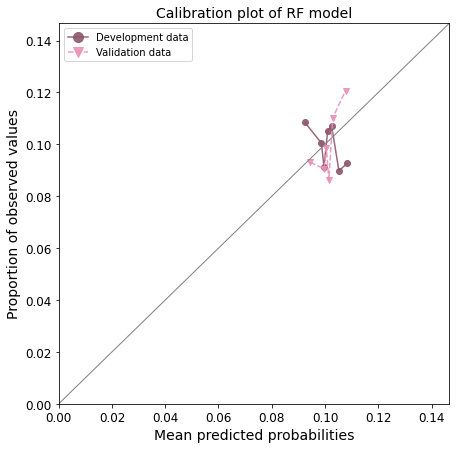

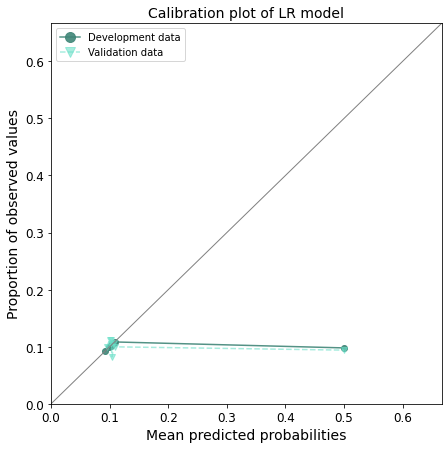

In [106]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_prepandemic, prob_pred_urti_no_abs_incdt_prepandemic_bin = cox_build('urti', 'incdt_prepandemic', data_urti_incdt_prepandemic, data_urti_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('urti', 'incdt_prepandemic_deciles', prob_pred_urti_no_abs_incdt_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26131 total observations, 25957 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 26131
number of events observed = 174
   partial log-likelihood = -1752.89
         time fit was run = 2023-07-15 12:39:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.79       0.21            -0.64             0.17                 0.53                 1.19
CCI_cat[T.medium]               -0.33       0.72       0.24            -0.80             0.14                 0.45                 1.15
CCI_cat[T.high]                 -0.31       0.73       0.29            -0.89             0.26                 0.41                 1.30
CCI_cat[T.very_high]            -0.51       0.60       0.27            -1.03             0.01                 0.36                 1.01
age_cat[T.25_34]                 0.05       1.05       0.28            -0.50             0.60                 0.60                 1.81
age_cat[T.35_44]                -0.01       0.99       0.28            -0.56             0.55                 0.57                 1.73
age_cat[T.45_54]                 0.03       1.03       0.28            -0.51             0.58                 0.60                 1.78
age_cat[T.55_64]                 0.03       1.03       0.28            -0.52             0.59                 0.59                 1.80
age_cat[T.65_74]                -0.02       0.98       0.29            -0.58             0.54                 0.56                 1.72
age_cat[T.75_more]              -0.14       0.87       0.29            -0.71             0.44                 0.49                 1.55
antibacterial_brit               0.00       1.00       0.05            -0.10             0.11                 0.91                 1.11
bmi_cat[T.obese]                 0.13       1.13       0.30            -0.45             0.71                 0.64                 2.03
bmi_cat[T.overweight]            0.22       1.25       0.35            -0.46             0.90                 0.63                 2.47
bmi_cat[T.underweight]           0.00       1.00       0.53            -1.03             1.03                 0.36                 2.81
bmi_cat[T.unknown]              -0.05       0.96       0.32            -0.67             0.58                 0.51                 1.79
ethnicity[T.other]              -0.26       0.77       0.40            -1.05             0.53                 0.35                 1.70
ethnicity[T.unknown]            -0.18       0.83       0.31            -0.79             0.42                 0.45                 1.53
ethnicity[T.white]              -0.06       0.94       0.28            -0.61             0.50                 0.54                 1.65
flu_vaccine[T.yes]               0.08       1.08       0.25            -0.41             0.57                 0.66                 1.76
imd[T.medium]                   -0.15       0.86       0.26            -0.66             0.37                 0.52                 1.45
imd[T.unaffluent]               -0.13       0.87       0.26            -0.65             0.38                 0.52                 1.47
imd[T.unknown]                   0.06       1.06       0.40            -0.72             0.84                 0.49                 2.31
imd[T.very_affluent]             0.29       1.34       0.24            -0.18             0.75                 0.84                 2.13
imd[T.very_unaffluent]           0.24       1.27       0.24            -0.23             0.71                 0.79                 2.04
region[T.east_midlands]         -0.40       0.67       0.43         

13044


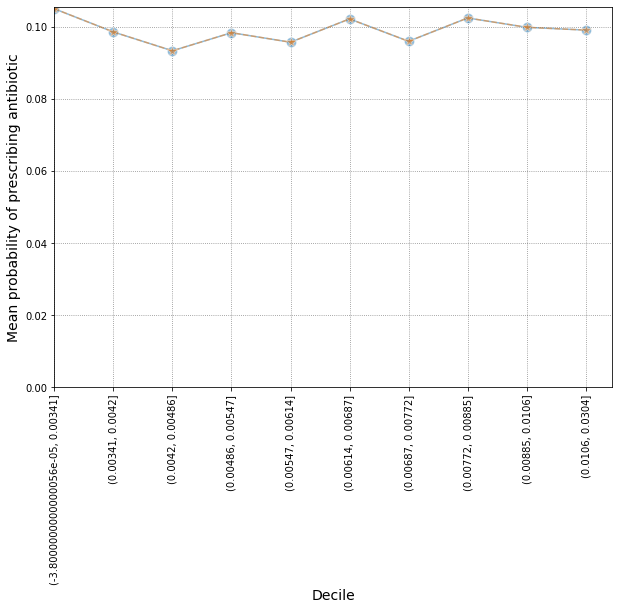

                           Logit Regression Results                           
Dep. Variable:              ab_binary   No. Observations:                29003
Model:                          Logit   Df Residuals:                    28994
Method:                           MLE   Df Model:                            8
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                 -0.1118
Time:                        13:39:14   Log-Likelihood:                -10374.
converged:                       True   LL-Null:                       -9330.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
bins_(0.00341, 0.0042]     -2.1882      0.061    -35.820      0.000      -2.308      -2.069
bins_(0.0042, 0.00486]     -2.2942      0.065    -35.392      0.000      -2.421      -2.167


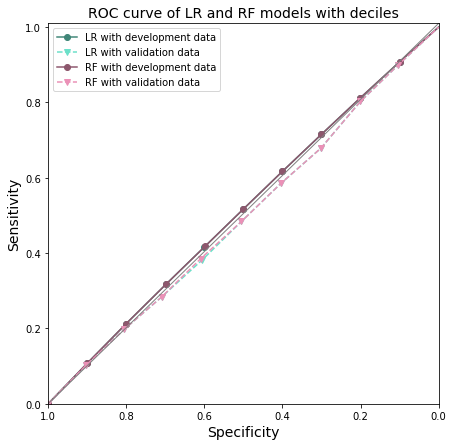

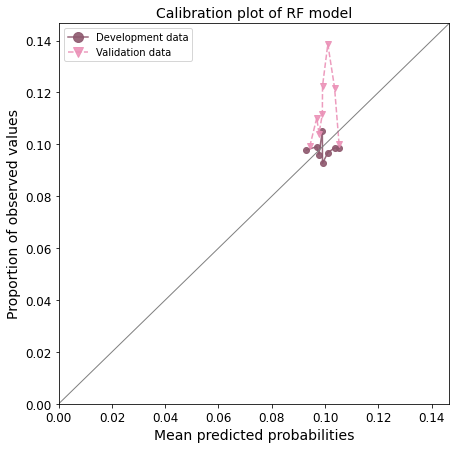

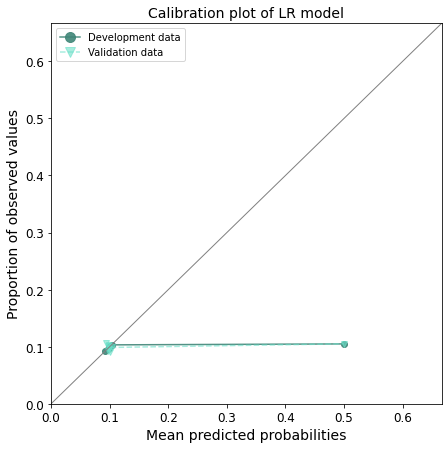

In [107]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_during_pandemic, prob_pred_urti_no_abs_incdt_during_pandemic_bin = cox_build('urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic, data_urti_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('urti', 'incdt_during_pandemic_deciles', prob_pred_urti_no_abs_incdt_during_pandemic)

    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 46112 total observations, 45805 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 46112
number of events observed = 307
   partial log-likelihood = -3274.22
         time fit was run = 2023-07-15 12:39:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.17            -0.34             0.32                 0.71                 1.38
CCI_cat[T.medium]                0.10       1.10       0.18            -0.26             0.46                 0.77                 1.58
CCI_cat[T.high]                 -0.11       0.90       0.23            -0.56             0.34                 0.57                 1.41
CCI_cat[T.very_high]            -0.06       0.94       0.20            -0.46             0.33                 0.63                 1.39
age_cat[T.25_34]                -0.15       0.86       0.22            -0.59             0.29                 0.55                 1.34
age_cat[T.35_44]                 0.11       1.12       0.21            -0.30             0.53                 0.74                 1.69
age_cat[T.45_54]                -0.22       0.80       0.23            -0.67             0.22                 0.51                 1.25
age_cat[T.55_64]                 0.18       1.20       0.21            -0.23             0.58                 0.80                 1.79
age_cat[T.65_74]                 0.17       1.19       0.21            -0.23             0.58                 0.79                 1.78
age_cat[T.75_more]              -0.00       1.00       0.22            -0.43             0.42                 0.65                 1.53
antibacterial_brit              -0.03       0.97       0.04            -0.11             0.05                 0.90                 1.05
bmi_cat[T.obese]                 0.29       1.34       0.24            -0.18             0.77                 0.83                 2.15
bmi_cat[T.overweight]            0.05       1.06       0.30            -0.53             0.64                 0.59                 1.89
bmi_cat[T.underweight]          -0.42       0.66       0.50            -1.41             0.56                 0.24                 1.76
bmi_cat[T.unknown]               0.42       1.52       0.25            -0.08             0.91                 0.93                 2.49
ethnicity[T.other]               0.20       1.22       0.29            -0.36             0.76                 0.70                 2.14
ethnicity[T.unknown]            -0.17       0.84       0.25            -0.66             0.32                 0.52                 1.37
ethnicity[T.white]               0.08       1.09       0.23            -0.36             0.52                 0.70                 1.69
flu_vaccine[T.yes]              -0.30       0.74       0.22            -0.73             0.12                 0.48                 1.13
imd[T.medium]                    0.07       1.08       0.18            -0.27             0.42                 0.76                 1.52
imd[T.unaffluent]               -0.15       0.86       0.19            -0.52             0.21                 0.60                 1.23
imd[T.unknown]                   0.15       1.16       0.26            -0.37             0.66                 0.69                 1.93
imd[T.very_affluent]            -0.07       0.93       0.18            -0.43             0.29                 0.65                 1.33
imd[T.very_unaffluent]          -0.27       0.76       0.19            -0.64             0.11                 0.53                 1.11
region[T.east_midlands]         -0.41       0.67       0.26         

13052


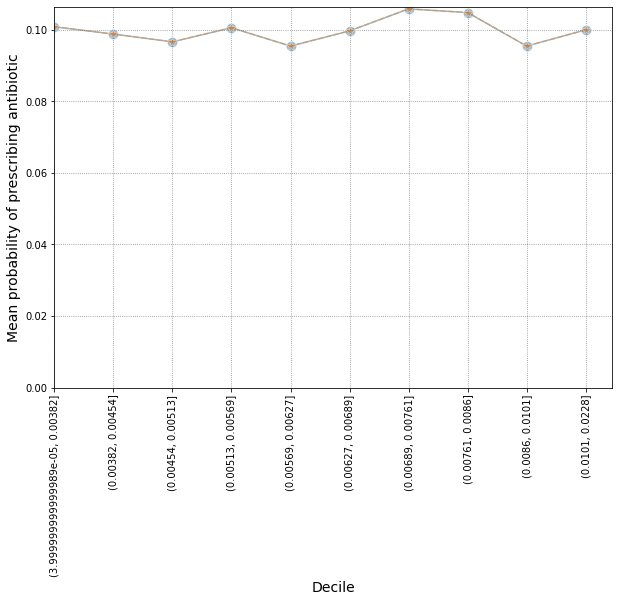

                           Logit Regression Results                           
Dep. Variable:              ab_binary   No. Observations:                51225
Model:                          Logit   Df Residuals:                    51216
Method:                           MLE   Df Model:                            8
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                 -0.1149
Time:                        13:39:21   Log-Likelihood:                -18430.
converged:                       True   LL-Null:                       -16530.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
bins_(0.00454, 0.00513]                  -2.2616      0.048    -47.545      0.000      -2.355      -2.168
bins_(0.00513, 0.00569]                  -2.2113  

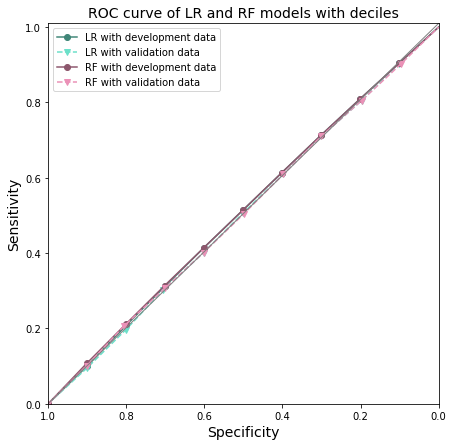

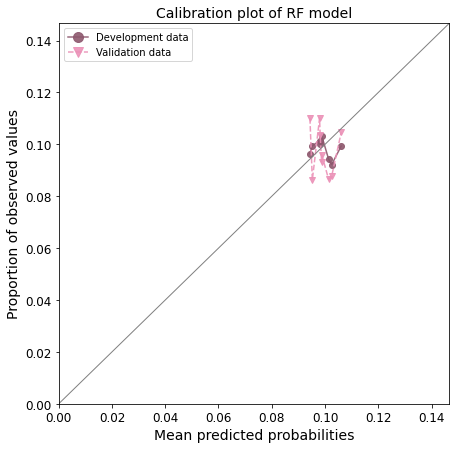

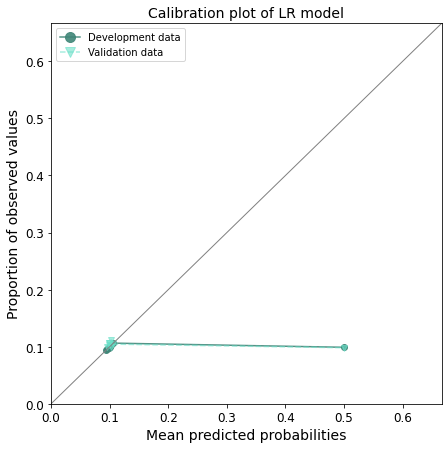

In [108]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_post_2nd_lockdown, prob_pred_urti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown, data_urti_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('urti', 'incdt_post_2nd_lockdown_deciles', prob_pred_urti_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3101 total observations, 3086 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3101
number of events observed = 15
   partial log-likelihood = -92.27
         time fit was run = 2023-07-15 12:39:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.56       1.75       0.85            -1.10             2.22                 0.33                 9.17
CCI_cat[T.medium]               -0.57       0.57       1.06            -2.64             1.50                 0.07                 4.50
CCI_cat[T.high]                 -0.38       0.68       1.29            -2.91             2.15                 0.05                 8.57
CCI_cat[T.very_high]             0.61       1.84       0.95            -1.26             2.48                 0.28                11.96
age_cat[T.25_34]                 1.52       4.56       1.20            -0.83             3.87                 0.44                47.72
age_cat[T.35_44]                 1.57       4.81       1.14            -0.67             3.81                 0.51                45.19
age_cat[T.45_54]                 1.55       4.73       1.18            -0.77             3.88                 0.46                48.29
age_cat[T.55_64]                 0.05       1.05       1.44            -2.78             2.87                 0.06                17.70
age_cat[T.65_74]                 0.97       2.64       1.18            -1.34             3.28                 0.26                26.51
age_cat[T.75_more]             -17.32       0.00    5509.13        -10815.01         10780.37                 0.00                  inf
antibacterial_brit               0.18       1.20       0.18            -0.18             0.54                 0.84                 1.72
bmi_cat[T.obese]                20.25   6.26e+08   22983.42        -45026.42         45066.93                 0.00                  inf
bmi_cat[T.overweight]           19.74   3.76e+08   22983.42        -45026.93         45066.42                 0.00                  inf
bmi_cat[T.underweight]          22.48   5.79e+09   22983.42        -45024.19         45069.15                 0.00                  inf
bmi_cat[T.unknown]              20.48   7.84e+08   22983.42        -45026.19         45067.15                 0.00                  inf
ethnicity[T.other]              18.64   1.25e+08    6988.88        -13679.31         13716.59                 0.00                  inf
ethnicity[T.unknown]            18.08   7.11e+07    6988.88        -13679.87         13716.03                 0.00                  inf
ethnicity[T.white]              18.06   6.96e+07    6988.88        -13679.89         13716.01                 0.00                  inf
flu_vaccine[T.yes]              -0.69       0.50       1.08            -2.81             1.43                 0.06                 4.19
imd[T.medium]                    1.61       5.03       1.12            -0.58             3.81                 0.56                45.32
imd[T.unaffluent]                1.24       3.46       1.13            -0.98             3.46                 0.38                31.82
imd[T.unknown]                 -18.10       0.00   10978.26        -21535.10         21498.90                 0.00                  inf
imd[T.very_affluent]             0.67       1.96       1.25            -1.77             3.12                 0.17                22.65
imd[T.very_unaffluent]           0.63       1.88       1.19            -1.70             2.97                 0.18                19.52
region[T.east_midlands]         18.82   1.49e+08    8821.92        -17271.

13357


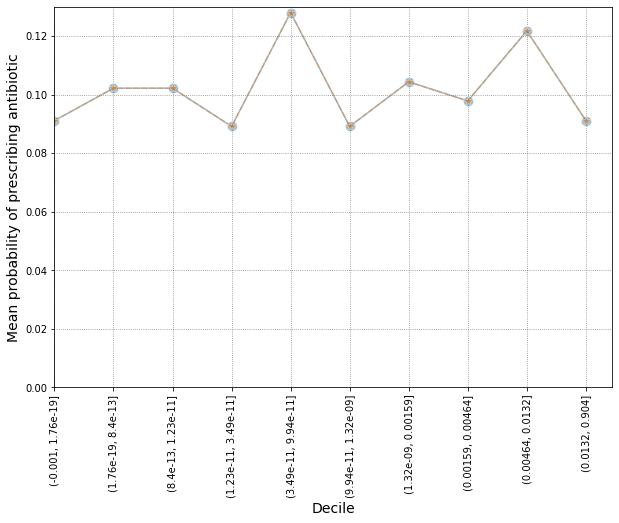

                           Logit Regression Results                           
Dep. Variable:              ab_binary   No. Observations:                 3452
Model:                          Logit   Df Residuals:                     3443
Method:                           MLE   Df Model:                            8
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                 -0.1106
Time:                        13:39:29   Log-Likelihood:                -1272.5
converged:                       True   LL-Null:                       -1145.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bins_(0.00159, 0.00464]      -2.2067      0.178    -12.391      0.000      -2.556      -1.858
bins_(0.00464, 0.0132]       -1.9556      0.161    -12.142      0.000      -2.271     

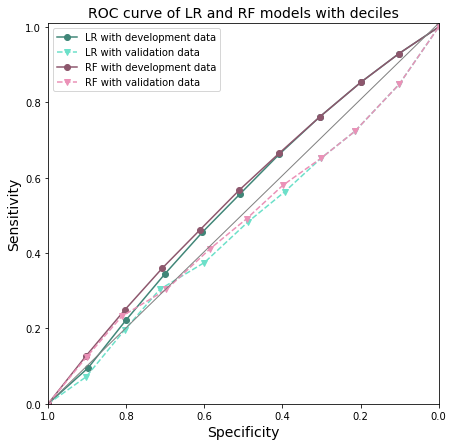

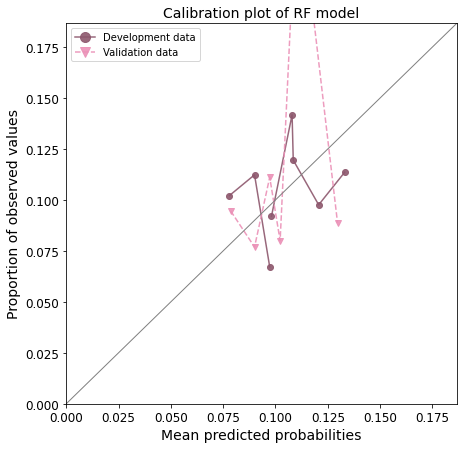

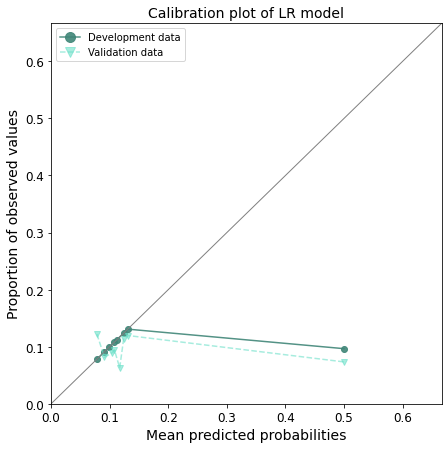

In [109]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_prepandemic, prob_pred_urti_no_abs_prevl_prepandemic_bin = cox_build('urti', 'prevl_prepandemic', data_urti_prevl_prepandemic, data_urti_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('urti', 'prevl_prepandemic_deciles', prob_pred_urti_no_abs_prevl_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2906 total observations, 2894 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 2906
number of events observed = 12
   partial log-likelihood = -81.35
         time fit was run = 2023-07-15 12:39:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.51       0.60       0.93            -2.33             1.31                 0.10                 3.69
CCI_cat[T.medium]               -0.34       0.71       1.02            -2.33             1.66                 0.10                 5.25
CCI_cat[T.high]                  0.56       1.75       1.02            -1.44             2.56                 0.24                12.95
CCI_cat[T.very_high]             0.37       1.44       0.93            -1.45             2.19                 0.23                 8.90
age_cat[T.25_34]               -18.28       0.00    6084.23        -11943.16         11906.60                 0.00                  inf
age_cat[T.35_44]                 0.36       1.43       0.94            -1.48             2.19                 0.23                 8.94
age_cat[T.45_54]                -0.89       0.41       1.25            -3.33             1.55                 0.04                 4.71
age_cat[T.55_64]                -0.02       0.98       1.03            -2.05             2.00                 0.13                 7.41
age_cat[T.65_74]                -0.81       0.45       1.24            -3.24             1.62                 0.04                 5.07
age_cat[T.75_more]               0.29       1.34       0.93            -1.53             2.11                 0.22                 8.27
antibacterial_brit              -0.00       1.00       0.21            -0.42             0.42                 0.66                 1.52
bmi_cat[T.obese]                -0.14       0.87       1.13            -2.35             2.07                 0.10                 7.90
bmi_cat[T.overweight]            0.89       2.44       1.20            -1.45             3.24                 0.23                25.56
bmi_cat[T.underweight]           1.11       3.02       1.48            -1.79             4.00                 0.17                54.87
bmi_cat[T.unknown]              -0.55       0.58       1.25            -3.01             1.91                 0.05                 6.76
ethnicity[T.other]              18.11   7.33e+07    7776.51        -15223.58         15259.80                 0.00                  inf
ethnicity[T.unknown]            18.30   8.83e+07    7776.51        -15223.39         15259.99                 0.00                  inf
ethnicity[T.white]              17.81   5.44e+07    7776.51        -15223.88         15259.50                 0.00                  inf
flu_vaccine[T.yes]              -0.35       0.71       1.07            -2.44             1.74                 0.09                 5.71
imd[T.medium]                   -0.37       0.69       0.78            -1.90             1.16                 0.15                 3.20
imd[T.unaffluent]               -0.99       0.37       0.90            -2.75             0.76                 0.06                 2.14
imd[T.unknown]                 -18.58       0.00    9995.80        -19609.99         19572.83                 0.00                  inf
imd[T.very_affluent]            -0.64       0.53       0.89            -2.38             1.10                 0.09                 3.01
imd[T.very_unaffluent]          -1.63       0.20       1.14            -3.85             0.60                 0.02                 1.82
region[T.east_midlands]        -18.55       0.00    7171.65        -14074.

13162


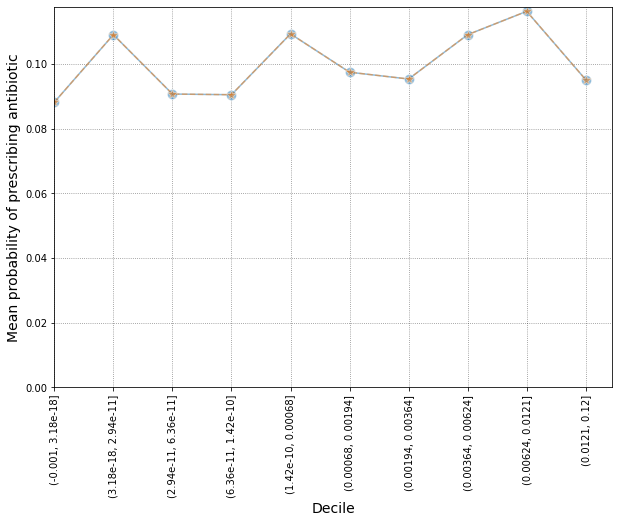

                           Logit Regression Results                           
Dep. Variable:              ab_binary   No. Observations:                 3229
Model:                          Logit   Df Residuals:                     3220
Method:                           MLE   Df Model:                            8
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                 -0.1148
Time:                        13:39:32   Log-Likelihood:                -1194.7
converged:                       True   LL-Null:                       -1071.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bins_(0.00068, 0.00194]      -2.2372      0.192    -11.647      0.000      -2.614      -1.861
bins_(0.00194, 0.00364]      -2.1226      0.181    -11.697      0.000      -2.478     

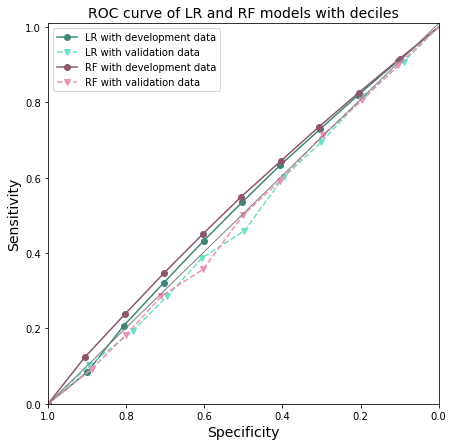

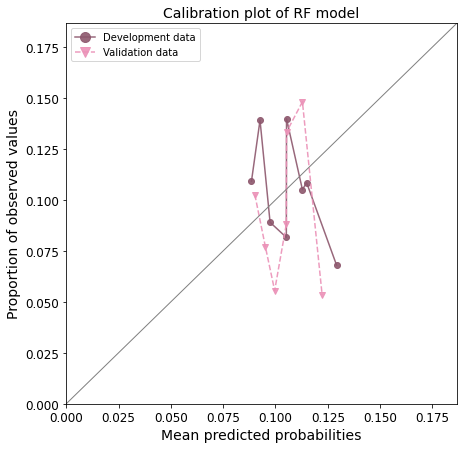

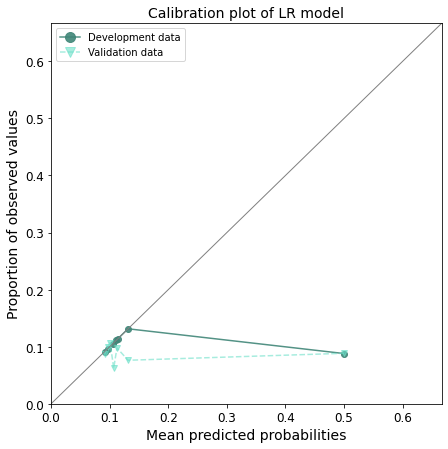

In [110]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_during_pandemic, prob_pred_urti_no_abs_prevl_during_pandemic_bin = cox_build('urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic, data_urti_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('urti', 'prevl_during_pandemic_deciles', prob_pred_urti_no_abs_prevl_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5030 total observations, 4997 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 5030
number of events observed = 33
   partial log-likelihood = -268.61
         time fit was run = 2023-07-15 12:39:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.54       1.71       0.65            -0.74             1.82                 0.48                 6.17
CCI_cat[T.medium]                0.88       2.42       0.67            -0.43             2.19                 0.65                 8.98
CCI_cat[T.high]                  0.47       1.60       0.82            -1.14             2.07                 0.32                 7.96
CCI_cat[T.very_high]             0.81       2.25       0.70            -0.55             2.18                 0.58                 8.80
age_cat[T.25_34]                -0.72       0.49       0.71            -2.11             0.67                 0.12                 1.96
age_cat[T.35_44]                -0.43       0.65       0.65            -1.70             0.84                 0.18                 2.31
age_cat[T.45_54]                -0.70       0.50       0.71            -2.09             0.69                 0.12                 2.00
age_cat[T.55_64]                 0.11       1.11       0.56            -0.99             1.20                 0.37                 3.33
age_cat[T.65_74]                -0.23       0.79       0.61            -1.42             0.96                 0.24                 2.62
age_cat[T.75_more]              -0.23       0.80       0.61            -1.42             0.97                 0.24                 2.63
antibacterial_brit               0.06       1.06       0.12            -0.18             0.30                 0.83                 1.34
bmi_cat[T.obese]                 1.17       3.23       1.02            -0.83             3.18                 0.43                24.10
bmi_cat[T.overweight]            0.83       2.29       1.16            -1.44             3.09                 0.24                22.06
bmi_cat[T.underweight]           1.02       2.78       1.42            -1.76             3.80                 0.17                44.71
bmi_cat[T.unknown]               0.62       1.86       1.08            -1.50             2.74                 0.22                15.55
ethnicity[T.other]              -0.19       0.83       0.92            -1.99             1.62                 0.14                 5.03
ethnicity[T.unknown]            -0.34       0.71       0.70            -1.70             1.03                 0.18                 2.79
ethnicity[T.white]              -0.06       0.95       0.62            -1.28             1.16                 0.28                 3.20
flu_vaccine[T.yes]              -1.31       0.27       1.02            -3.30             0.68                 0.04                 1.98
imd[T.medium]                    0.48       1.62       0.73            -0.95             1.92                 0.39                 6.81
imd[T.unaffluent]                1.02       2.76       0.68            -0.32             2.35                 0.73                10.48
imd[T.unknown]                   1.07       2.92       0.92            -0.73             2.87                 0.48                17.63
imd[T.very_affluent]             0.44       1.55       0.73            -1.00             1.87                 0.37                 6.49
imd[T.very_unaffluent]           1.14       3.12       0.66            -0.15             2.43                 0.86                11.38
region[T.east_midlands]          0.84       2.32       0.84            -0

13040


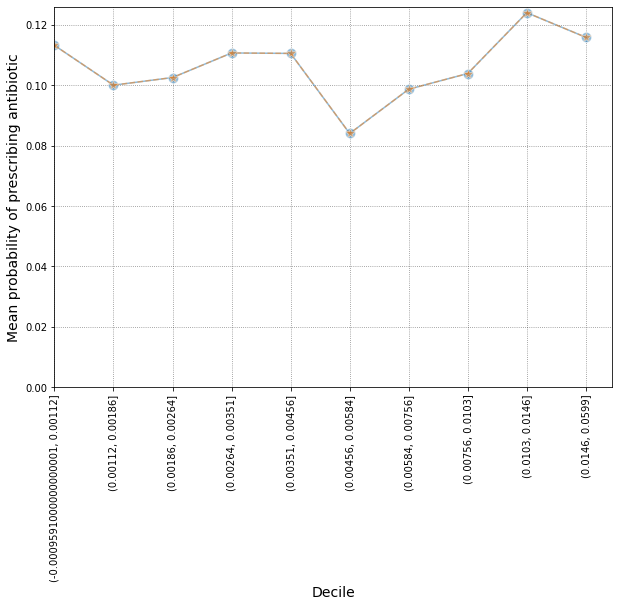

                           Logit Regression Results                           
Dep. Variable:              ab_binary   No. Observations:                 5628
Model:                          Logit   Df Residuals:                     5619
Method:                           MLE   Df Model:                            8
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                -0.09889
Time:                        13:39:36   Log-Likelihood:                -2103.5
converged:                       True   LL-Null:                       -1914.2
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
bins_(0.00112, 0.00186]    -2.3552      0.148    -15.916      0.000      -2.645      -2.065
bins_(0.00186, 0.00264]    -2.0502      0.132    -15.558      0.000      -2.308      -1.792


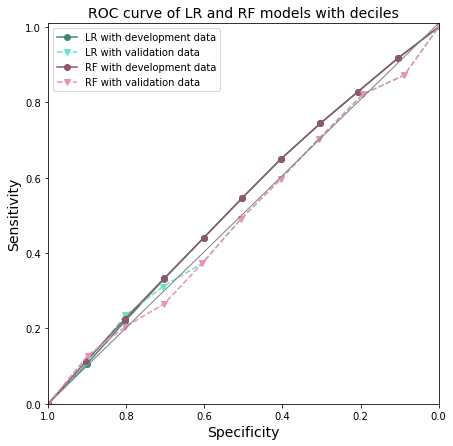

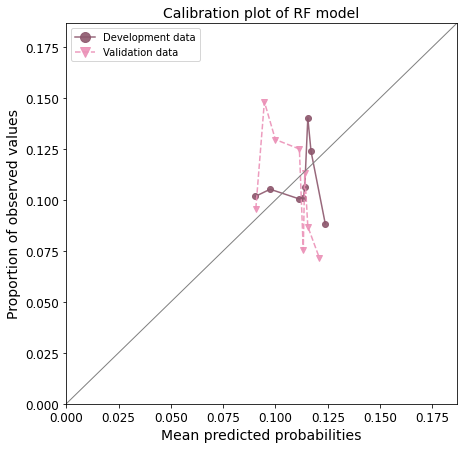

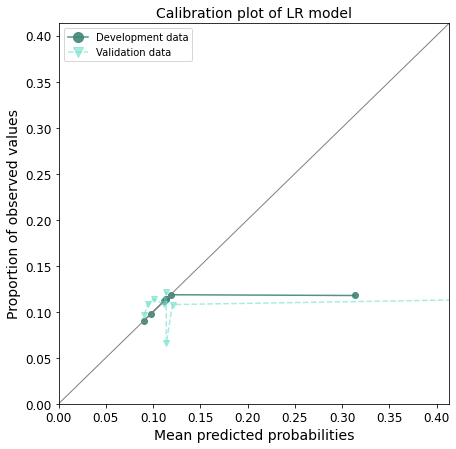

In [111]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_post_2nd_lockdown, prob_pred_urti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown, data_urti_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('urti', 'prevl_post_2nd_lockdown_deciles', prob_pred_urti_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")